In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

import vaex
import os

from cycler import cycler

for i in {0..2}; do python3 dataGenerator.py; done

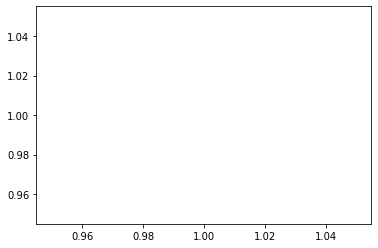

In [2]:


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.rcParams["axes.prop_cycle"] = cycler("color",('indigo','b','r','k','#ff7f0e','g'))
plt.show()

In [3]:
#path = "/net/virgo01/data/users/spirov/Blk/Nexus Project/torchData"
p2 = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Training/"
p3 = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"


In [4]:
df = vaex.open(p2+"1716300317.2928512.hdf5")

In [5]:
df

#,R,Th,Fi,CZ
0,31646.162961670558,2.1390826590784418,2.2061568354611305,30482.8065700176
1,31501.54685289649,2.1876205480685087,2.269380145398704,31870.702325916347
2,32219.752614985406,2.149529474735148,2.1982821491320457,20277.255144189832
3,33237.35683278686,2.1872461862925983,2.220964807494919,27979.381651442367
4,30762.906318101057,2.1072605779979297,2.1834132393197123,30870.497193983945
...,...,...,...,...
"111,987",44489.51440048015,0.7633402998269055,-2.492251744360703,41646.55574536911
"111,988",36933.7968317513,2.050070231118433,-3.1021895584564096,36674.09139869391
"111,989",49928.165877541294,2.036494023736392,-2.181266890883465,50007.98241232911
"111,990",32970.280079230724,1.6507252713084437,-2.725911735212825,32640.666805215893


In [6]:
lim = 10
sc = 1e4

class CustomVaexDataset(Dataset):
    def __init__(self,frameDir):
        self.lengt = len(os.listdir(frameDir))
        self.frameDir = frameDir
    
    def __len__(self):
        return self.lengt
        
        
    def __getitem__(self,idx):
        fil = self.frameDir+os.listdir(self.frameDir)[idx]
        df = vaex.open(fil)
        
        th = df.Th.values[::lim]
        fi = df.Fi.values[::lim]
        R = df.R.values[::lim]/sc
        CZ = df.CZ.values[::lim]/sc
        
        broken = np.array((CZ,th,fi))
        truth = np.array(R)
        
        return torch.tensor(broken), torch.tensor(truth)
                 
                 
                 

In [7]:
p2

'/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Training/'

In [8]:
ds = CustomVaexDataset(p2)

In [9]:
a,b = ds.__getitem__(0)

In [10]:
a.size()

torch.Size([3, 11200])

In [11]:
b.size()

torch.Size([11200])

# Dloader

In [12]:
train_set = CustomVaexDataset(p2)
test_set = CustomVaexDataset(p3)


In [13]:
train_dataloader = DataLoader(train_set, batch_size=36, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=12, shuffle=True)

In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([36, 3, 11200])
Labels batch shape: torch.Size([36, 11200])


In [15]:
img = train_features[0].squeeze()
label = train_labels[0]

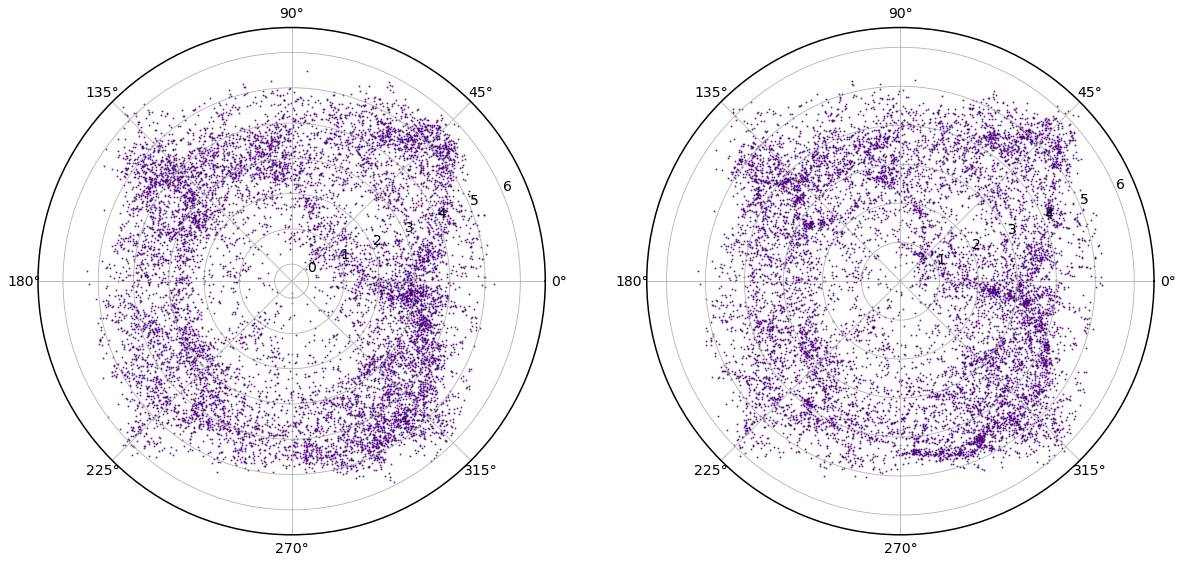

In [16]:


plt.figure(figsize=(20,10))
plt.subplot(121,projection="polar")
plt.scatter(img[2],img[0],s=0.1*lim,alpha=0.7)
#plt.ylim(0,4e4)

plt.subplot(122,projection="polar")
plt.scatter(img[2],label,s=0.1*lim,alpha=0.7)
#plt.ylim(0,4e4)
plt.show()

# Neural Network

In [17]:
torch.set_default_dtype(img.dtype)

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [29]:
n = int(2**12)
l=train_labels.size()[1]

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * l, n),
            nn.ReLU(),
            nn.Linear(n,n),
            nn.ReLU(),
            nn.Linear(n,n),
            nn.Sigmoid(),
            nn.Linear(n,n),
            nn.ReLU(),
            nn.Linear(n,l)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [30]:
Ls = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 4 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: [{current:>5d}/{size:>5d}]  {loss:>7f}")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred.argmax(0) - y).abs()<bmark).type(torch.float).sum().item()

    test_loss /= num_batches
    
    correct /= size*y.size()[1] 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    Ls.append(test_loss)

In [31]:
#hyperparams
learning_rate = 1e-1 #sc/1e5
batch_size = 16
epochs = 50
bmark = 1e3/sc
train_dtataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
loss_fn = nn.MSELoss() #
#loss_fn = nn.KLDivLoss()

model = NeuralNetwork()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #Adam

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: [   16/  512]  14.019133
loss: [   80/  512]  14.496695
loss: [  144/  512]  15.603866
loss: [  208/  512]  16.359201
loss: [  272/  512]  16.375907
loss: [  336/  512]  16.751578
loss: [  400/  512]  17.104024
loss: [  464/  512]  17.141276
Test Error: 
 Accuracy: 0.0%, Avg loss: 17.176453 

Epoch 2
-------------------------------
loss: [   16/  512]  17.032997
loss: [   80/  512]  17.190655
loss: [  144/  512]  17.138599
loss: [  208/  512]  17.284306
loss: [  272/  512]  17.411201
loss: [  336/  512]  17.217650
loss: [  400/  512]  17.282086
loss: [  464/  512]  17.702887
Test Error: 
 Accuracy: 0.0%, Avg loss: 17.326397 

Epoch 3
-------------------------------
loss: [   16/  512]  17.324743
loss: [   80/  512]  17.266098
loss: [  144/  512]  17.316827
loss: [  208/  512]  17.273455
loss: [  272/  512]  17.069457
loss: [  336/  512]  17.271993
loss: [  400/  512]  17.303458
loss: [  464/  512]  17.152204
Test Error: 
 Accuracy: 0.0%, Av

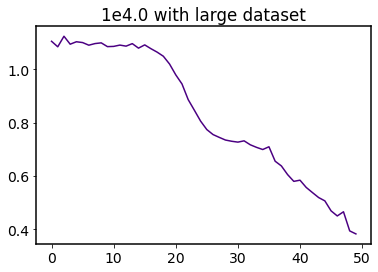

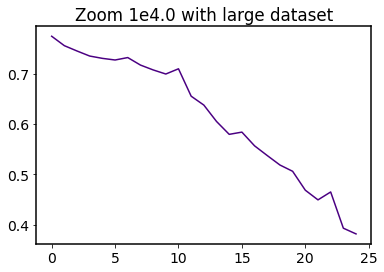

In [34]:
plt.plot((Ls[:]))
plt.title(f"1e{np.log10(sc)} with large dataset")
#plt.yscale('log')
plt.show()
plt.plot((Ls[25:]))
plt.title(f"Zoom 1e{np.log10(sc)} with large dataset")
#plt.yscale('log')
plt.show()

In [118]:
label.shape

torch.Size([11200])

In [124]:
img.flatten()

tensor([ 2.6250,  2.3343,  1.7490,  ..., -0.6890,  0.5384, -1.3716])

In [129]:
mod.squeeze().shape

torch.Size([16, 11200])

In [131]:
train_labels.shape

torch.Size([16, 11200])

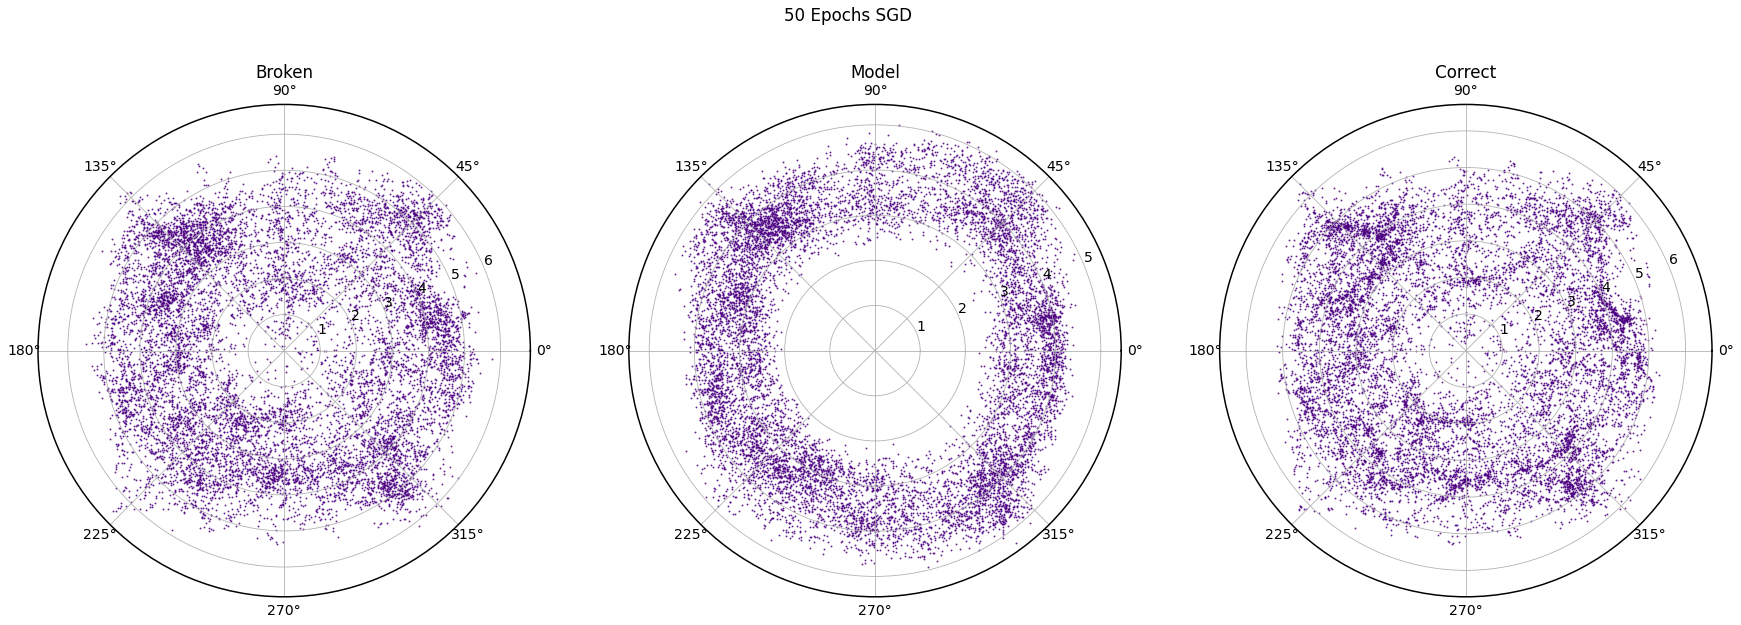

In [38]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]

with torch.no_grad():
    mod = model(train_features)[0]

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.scatter(img[2],img[0],s=0.1*lim,alpha=0.7)
#plt.ylim(0,4e4)
plt.title("Broken")

plt.subplot(132,projection="polar")
plt.scatter(img[2],mod,s=0.1*lim,alpha=0.7)
plt.title("Model")

plt.subplot(133,projection="polar")
plt.scatter(img[2],label,s=0.1*lim,alpha=0.7)
#plt.ylim(0,4e4)
plt.title("Correct")

plt.suptitle("50 Epochs SGD")
plt.show()

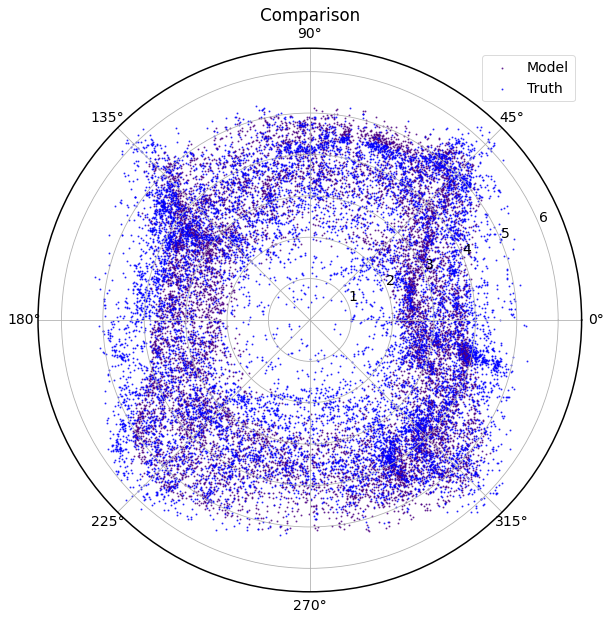

In [36]:

plt.figure(figsize=(10,10))
plt.subplot(projection="polar")
plt.scatter(img[2],mod,s=0.1*lim,alpha=0.7,label="Model")

plt.scatter(img[2],label,s=0.1*lim,alpha=0.7,label="Truth")
#plt.ylim(0,4e4)
plt.title("Comparison")
plt.legend()
plt.show()

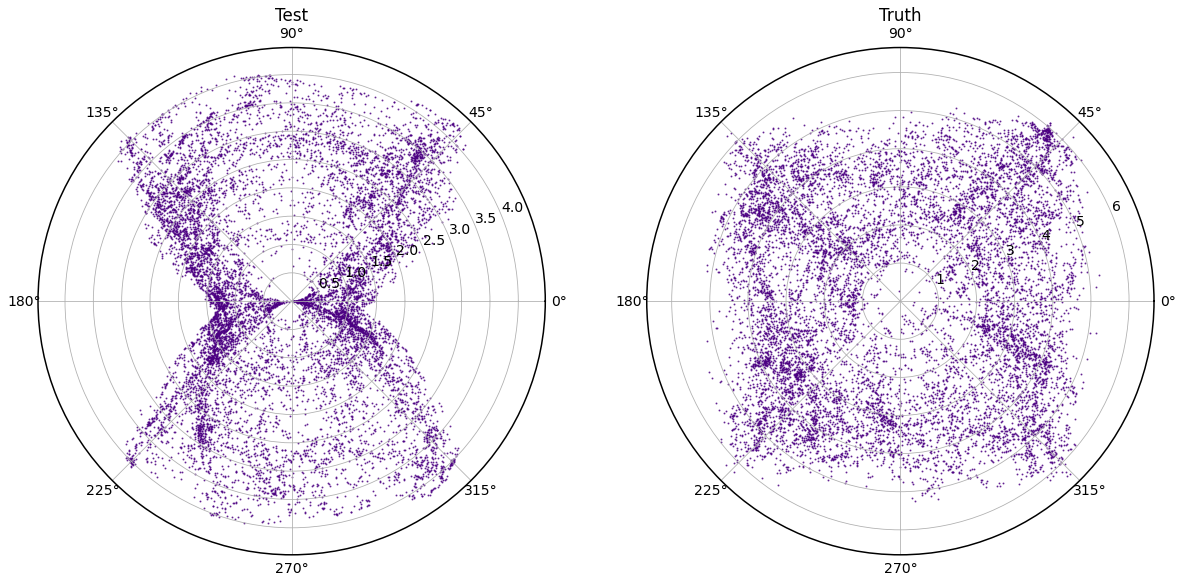

In [28]:

plt.figure(figsize=(20,10))
plt.subplot(121,projection="polar")
plt.scatter(img[2],(mod-mod.min())*15,s=0.1*lim,alpha=0.7,label="Model")

plt.title("Test")


plt.subplot(122,projection="polar")
plt.scatter(img[2],label,s=0.1*lim,alpha=0.7,label="Truth")
#plt.ylim(0,4e4)
plt.title("Truth")

plt.show()

# Goals:



> ~create dataset of some size~

> ~load data~

> construct model with appropriate architecture